In [ ]:
# git repo
!git clone https://github.com/gjvarun0307/ConvNeXt-from-Scratch.git

In [ ]:
%load_ext tensorboard

In [ ]:
%%capture
!pip install torchvision --upgrade

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir -p /content/drive/MyDrive/Models/convnext-food101/weights
!mkdir -p /content/drive/MyDrive/Models/convnext-food101/dataset
!mkdir -p /content/drive/MyDrive/Models/convnext-food101/runs/convNextmodel

In [61]:
import torch
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import requests

from model import get_model
from config import get_config

In [13]:
%%capture
FOOD101_CLASSES = ["apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare", "beet_salad", "beignets", "bibimbap", "bread_pudding", "breakfast_burrito", "bruschetta", "caesar_salad", "cannoli", "caprese_salad", "carrot_cake", "ceviche", "cheesecake", "cheese_plate", "chicken_curry", "chicken_quesadilla", "chicken_wings", "chocolate_cake", "chocolate_mousse", "churros", "clam_chowder", "club_sandwich", "crab_cakes", "creme_brulee", "croque_madame", "cup_cakes", "deviled_eggs", "donuts", "dumplings", "edamame", "eggs_benedict", "escargots", "falafel", "filet_mignon", "fish_and_chips", "foie_gras", "french_fries", "french_onion_soup", "french_toast", "fried_calamari", "fried_rice", "frozen_yogurt", "garlic_bread", "gnocchi", "greek_salad", "grilled_cheese_sandwich", "grilled_salmon", "guacamole", "gyoza", "hamburger", "hot_and_sour_soup", "hot_dog", "huevos_rancheros", "hummus", "ice_cream", "lasagna", "lobster_bisque", "lobster_roll_sandwich", "macaroni_and_cheese", "macarons", "miso_soup", "mussels", "nachos", "omelette", "onion_rings", "oysters", "pad_thai", "paella", "pancakes", "panna_cotta", "peking_duck", "pho", "pizza", "pork_chop", "poutine", "prime_rib", "pulled_pork_sandwich", "ramen", "ravioli", "red_velvet_cake", "risotto", "samosa", "sashimi", "scallops", "seaweed_salad", "shrimp_and_grits", "spaghetti_bolognese", "spaghetti_carbonara", "spring_rolls", "steak", "strawberry_shortcake", "sushi", "tacos", "takoyaki", "tiramisu", "tuna_tartare", "waffles", ""]
FOOD101_CLASSES

In [18]:
def load_model(config, model_path, device):
  model = get_model(config)

  # Load weights
  print(f"Loading weights from {model_path}...")
  checkpoint = torch.load(model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])

  model.to(device)
  model.eval()
  return model

def predict_food(model, image_path, device):
  preprocess = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

  img = Image.open(image_path).convert('RGB')

  img_tensor = preprocess(img)
  img_tensor = img_tensor.unsqueeze(0) # Add batch dimension (1, 3, 224, 224)
  img_tensor = img_tensor.to(device)

  with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

  # Top 3
  top_prob, top_catid = torch.topk(probabilities, 5)

  results = []
  for i in range(top_prob.size(1)):
      score = top_prob[0][i].item() * 100
      class_name = FOOD101_CLASSES[top_catid[0][i].item()]
      results.append((class_name, score))

  return img, results

def visualize_prediction(img, results):
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')

    title_text = "Predictions:\n"
    for name, score in results:
        title_text += f"{name}: {score:.2f}%\n"

    plt.title(title_text, loc='left', fontsize=12, backgroundcolor='white')
    plt.show()

Loading weights from /content/drive/MyDrive/Models/convnext-food101/weights/convnextmodel_best_model...
takoyaki             | 97.26%
strawberry_shortcake | 0.18%
dumplings            | 0.15%
spring_rolls         | 0.13%
tacos                | 0.11%


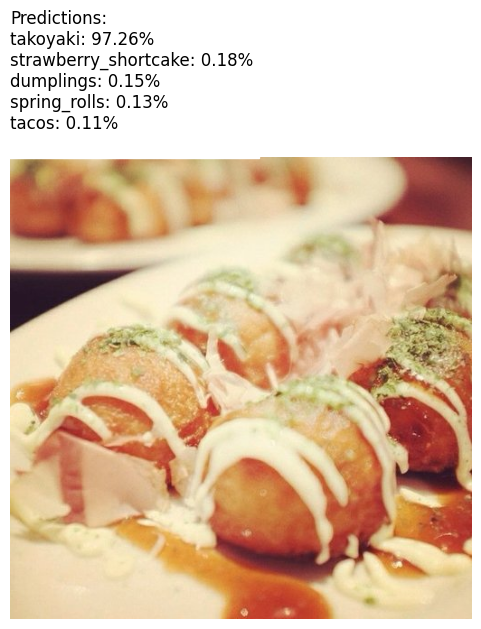

In [25]:
config = get_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/Models/convnext-food101/weights/convnextmodel_best_model"
test_image = "/content/dataset/food-101/images/takoyaki/1495491.jpg"

model = load_model(config, model_path, device)
original_img, preds = predict_food(model, test_image, device)

for name, score in preds:
    print(f"{name:<20} | {score:.2f}%")

visualize_prediction(original_img, preds)

In [67]:
def image_from_url(image_url):

  image_name = image_url.split('/')[-1]

  img_data = requests.get(image_url).content
  with open(image_name, 'wb') as handler:
      handler.write(img_data)

  return image_name

samosa               | 27.89%
grilled_cheese_sandwich | 15.97%
gyoza                | 15.89%
chicken_quesadilla   | 5.56%
spring_rolls         | 5.47%


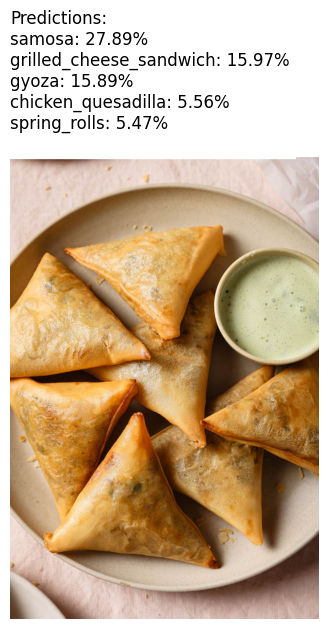

In [68]:
url = 'https://www.teaforturmeric.com/wp-content/uploads/2025/02/Keema-Samosa-05.jpg'
original_img, preds = predict_food(model, image_from_url(url), device)

for name, score in preds:
    print(f"{name:<20} | {score:.2f}%")

visualize_prediction(original_img, preds)

bruschetta           | 87.65%
huevos_rancheros     | 2.90%
breakfast_burrito    | 1.16%
tacos                | 1.06%
chicken_quesadilla   | 0.79%


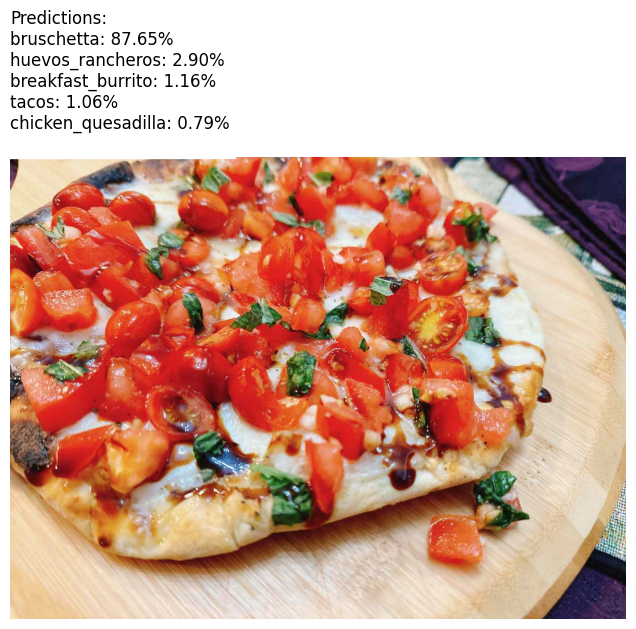

In [70]:
url = 'https://www.allrecipes.com/thmb/TdELPg_zAgRqZ8wCpXK7fLKaDzY=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/7503843_Bruschetta-Pizza_TheDailyGourmet_4x3-b5cc56213253471db4b1b6a1287f4376.jpg'
original_img, preds = predict_food(model, image_from_url(url), device)

for name, score in preds:
    print(f"{name:<20} | {score:.2f}%")

visualize_prediction(original_img, preds)

hamburger            | 22.98%
pulled_pork_sandwich | 9.23%
apple_pie            | 7.14%
club_sandwich        | 6.60%
lasagna              | 5.52%


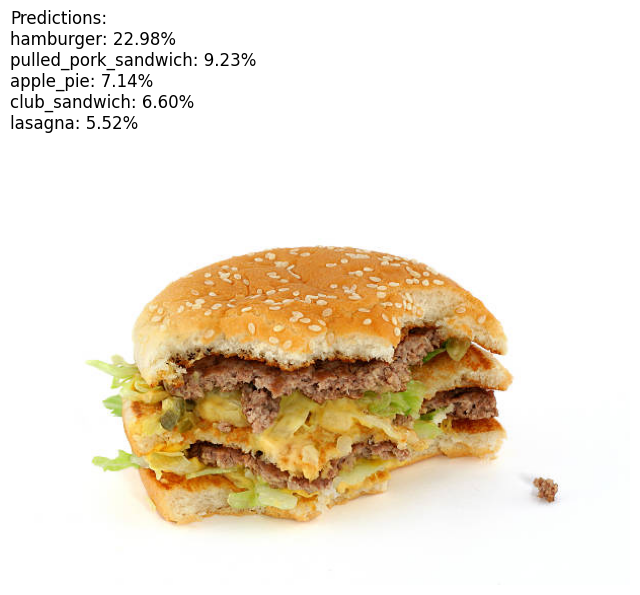

In [71]:
url = 'https://media.istockphoto.com/id/140262179/photo/half-eaten-delicious-hamburger.jpg?s=612x612&w=0&k=20&c=Tn9o3vBEDP8uVhlAsI75N4YVyGnih1Y1-3Imk4DKpBk='
original_img, preds = predict_food(model, image_from_url(url), device)

for name, score in preds:
    print(f"{name:<20} | {score:.2f}%")

visualize_prediction(original_img, preds)